In [1]:
#add necessary libraries
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import numpy.matlib as npm
import os

import torch
import torch.nn as nn
import torch.utils.data

from mpl_toolkits import mplot3d

%matplotlib inline

In [2]:
np.random.seed(112)

In [3]:
class autoencoder(nn.Module):
    def __init__(self,inputD,encoding_dim):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential()
        
        self.encoder.add_module("enc_0", nn.Linear(inputD,encoding_dim[0]))
        self.encoder.add_module("relu_0", nn.ReLU())
          
        for l in range(1,len(encoding_dim)):
            self.encoder.add_module("enc_"+str(l), nn.Linear(encoding_dim[l-1],encoding_dim[l]))
            self.encoder.add_module("encBn_"+str(l),nn.BatchNorm1d(encoding_dim[l]))
            self.encoder.add_module("encrelu_"+str(l), nn.ReLU())
                                    
        self.decoder = nn.Sequential()
        
        for l in range(len(encoding_dim)-1,0,-1):
            self.decoder.add_module("dec_"+str(l), nn.Linear(encoding_dim[l],encoding_dim[l-1]))
            self.decoder.add_module("decBn_"+str(l),nn.BatchNorm1d(encoding_dim[l-1]))
            self.decoder.add_module("decrelu_"+str(l), nn.ReLU())
            
        self.decoder.add_module("dec_0", nn.Linear(encoding_dim[0],inputD))
        self.decoder.add_module("decrelu_0", nn.Sigmoid())
        
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def init_weights(self,m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def representation(self, x):
        x = self.encoder(x)
        return x

In [4]:
def testAutoEncoderFit(matrix, encoding_dim,three_D=False,scatter=False):
    matrixtensor = torch.tensor(matrix).float()
    
    input_dim = matrix.shape[1]
    model = autoencoder(input_dim,encoding_dim).cuda()
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    
    data_tensor = torch.utils.data.TensorDataset(matrixtensor, matrixtensor) 
    dataloader = torch.utils.data.DataLoader(dataset = data_tensor, batch_size = batch_size, shuffle = True)
    
    for epoch in range(num_epochs):
        for data in dataloader:
            X, _ = data
            X = X.cuda()
            # ===================forward=====================
            output = model(X)
            loss = criterion(output, X)
            MSE_loss = nn.MSELoss()(output, X)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
#         print('epoch [{}/{}], loss:{:.4f}, MSE_loss:{:.4f}'
#             .format(epoch + 1, num_epochs, loss.item(), MSE_loss.item()))   
    
    with torch.no_grad():
        reconMatrixAE = model(matrixtensor.cuda()).cpu().numpy()
    reconCostAE = np.mean(np.power(reconMatrixAE - matrix,2),axis = 1)
    reconCostAE = reconCostAE.reshape(-1, 1)
    
    
    if three_D:
        if scatter:
            fig = plt.figure(figsize=(10,6))
            ax = plt.axes(projection='3d')
            #ax.plot_wireframe(matrix[:,0],matrix[:,1],matrix[:,2])
            ax.scatter3D(reconMatrixAE[:,0],reconMatrixAE[:,1],reconMatrixAE[:,2])
            #plt.savefig('C:\\Projekte\\dev\\git\\Masterarbeit\\AE_Tests\\Nicht_LinearerFall\\3D_Scatter_mitPCA.png')
            
        else:
            X = reconMatrixAE[:,0].reshape(samples,samples)
            Y = reconMatrixAE[:,1].reshape(samples,samples)
            Z = reconMatrixAE[:,2].reshape(samples,samples)

            fig = plt.figure(figsize=(10,6))
            ax = plt.axes(projection='3d')
            ax.plot_wireframe(X,Y,Z)
            #plt.savefig('C:\\Projekte\\dev\\git\\Masterarbeit\\AE_Tests\\Nicht_LinearerFall\\3D_mitPCA.png')

    else:
        fig = plt.figure(figsize=(10,6))
        plt.plot(reconMatrixAE[:,0],reconMatrixAE[:,1])
        #plt.savefig('C:\\Projekte\\dev\\git\\Masterarbeit\\AE_Tests\\Nicht_LinearerFall\\2D_mitPCA.png')
    
    
    print('Reconstruction MSE : ',np.mean(reconCostAE))
    return np.mean(reconCostAE)

## ----------------------------------------------------------------------------------------------------------------------------------
# Test in 2D

In [5]:
samples = 400
matrix = np.empty((samples,2))
matrix[:,0] = np.linspace(0,1000,samples)
matrix[:,1] = matrix[:,0]**2 + 20
#matrix = matrix + 10 * np.random.normal(size=matrix.shape)
matrix.shape

for i in range(matrix.shape[1]):
    matrix[:, i] = (matrix[:, i] - matrix[:, i].min()) / (matrix[:, i].max() - matrix[:, i].min())

Reconstruction MSE :  0.0002137735276439014


0.0002137735276439014

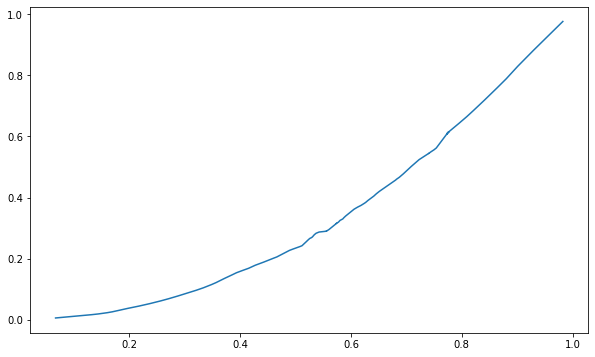

In [7]:
encoding_dim = [100,50,1]
learning_rate=0.0001
batch_size = 100
num_epochs = 1000
testAutoEncoderFit(matrix,encoding_dim)

## ----------------------------------------------------------------------------------------------------------------------------------
# Test in 3D

In [8]:
samples = 20
x = np.linspace(0,1,samples)
y = x
X,Y = np.meshgrid(x,y)
Z = Y**4 + X**4+ 20

matrix = np.empty((samples*samples,3))
matrix[:,0] = X.reshape(samples*samples)
matrix[:,1] = Y.reshape(samples*samples)
matrix[:,2] = Z.reshape(samples*samples)
for i in range(matrix.shape[1]):
    matrix[:, i] = (matrix[:, i] - matrix[:, i].min()) / (matrix[:, i].max() - matrix[:, i].min())

Reconstruction MSE :  0.0012937545972815862


0.0012937545972815862

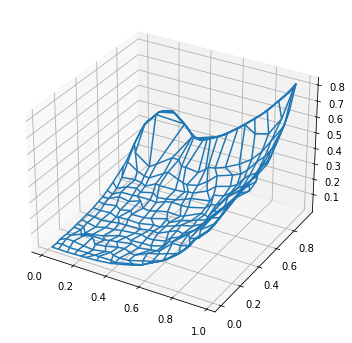

In [9]:
encoding_dim = [100,30,2]
learning_rate=0.0001
batch_size = 100
num_epochs = 1000
testAutoEncoderFit(matrix,encoding_dim,True)

## ----------------------------------------------------------------------------------------------------------------------------------
# Test in 3D mit Scatter

In [10]:
samples = 400
matrix = np.random.uniform(low=0,high=1,size=(samples,3))

Reconstruction MSE :  0.00971936596681034


0.00971936596681034

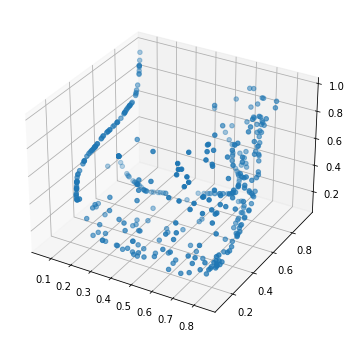

In [11]:
encoding_dim = [100,30,2]
learning_rate=0.001
batch_size = 100
num_epochs = 100
testAutoEncoderFit(matrix,encoding_dim,True,scatter=True)